 # CNN on CIFAR 

In this problem, we will train a CNN on CIFAR-10 database. Next, we will go through the network and visualize its layers to see what is happening there. Then, we use the trained model in a Transfer Learning approach to classifying the CIFAR-100 database.

Let's start with loading data. First load the data by runing the code below:

In [2]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [3]:
#this cell is order to use google colab and file directory of google drive

from google.colab import files
src = list(files.upload().values())[0]
open('load_data.py','wb').write(src)
import load_data

Saving load_data.py to load_data.py


In [4]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [5]:
#this cell is order to use google colab and file directory of google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
from load_data import load_cifar10 #this function provided in the attached file loads the data of CIFAR10 database

def load_cifar10_data():
    dataset_dir = 'drive/MyDrive/colabs/CNN on CIFAR/data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_cifar10(dataset_dir)
    X_train, X_val = X_train[:45000], X_train[45000:]
    y_train, y_val = y_train[:45000], y_train[45000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


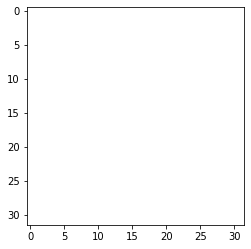

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[100])#represnting a sample data from CIFAR-10
plt.show()

By successfully runing the above code, we have loaded the data and also we can see a sample data from CIFAR-10.

The below code will convert the labels to one-hot codes which will be later used for the classification.

In [8]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(y_train)#this line will fit 'encoder' to encode the labels

y_train_onehot = encoder.transform(y_train)# encoding train labels (one-hot coding)
y_val_onehot   = encoder.transform(y_val)  # encoding train labels (one-hot coding)
y_test_onehot  = encoder.transform(y_test) # encoding test  labels (one-hot coding)

The function below is for converting data to several batches which we will use in training.

In [9]:
def make_batches(x, y, batch_size):
    n = len(y)
    steps = n // batch_size
    if n % batch_size != 0:
        steps += 1
    x_batches = np.array_split(x, steps)
    y_batches = np.array_split(y, steps)
    return x_batches, y_batches

## Part1: Trainig a CNN 

In this part, we are going to train a Convolutional Neural Network (CNN) with the below structure:

1. 16 * conv(5,5), activation function =ReLU
2. 16 * conv(5,5), activation function =ReLU
3. Max-pooling(3,3), stride=(2,2)
4. 32 * conv(5,5), activation function =ReLU
5. 32 * conv(5,5), activation function =ReLU
6. Max-pooling(3,3), stride=(2,2)
7. 64 * conv(5,5), activation function =ReLU
8. FC(128), activation function =ReLU
9. FC(128), activation function =ReLU
10. FC(10), activation function =softmax

Let's go to implement the model in the below box.

In [23]:

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y = tf.placeholder(tf.float32, [None, 10])# placeholder for labels (one-hot encoded)

###################################################################
#########       code for implementing the network       ###########
###################################################################

# Define the needed Variables here:
# e.g., W_conv1 has the shape of shape=[5, 5, 3, 16] and B_conv1 has the shape of shape=[16]


W_conv1 = tf.Variable(tf.random.normal([5, 5, 3, 16], mean= 0, stddev= 0.1), name="wc1")
W_conv2 = tf.Variable(tf.random.normal([5, 5, 16, 16], mean= 0, stddev= 0.1), name="wc2")
W_conv3 = tf.Variable(tf.random.normal([5, 5, 16, 32], mean= 0, stddev= 0.1), name="wc3")
W_conv4 = tf.Variable(tf.random.normal([5, 5, 32, 32], mean= 0, stddev= 0.1), name="wc4")
W_conv5 = tf.Variable(tf.random.normal([5, 5, 32, 64], mean= 0, stddev= 0.1), name="wc5")

B_conv1 = tf.Variable(tf.zeros((16)))
B_conv2 = tf.Variable(tf.zeros((16)))
B_conv3 = tf.Variable(tf.zeros((32)))
B_conv4 = tf.Variable(tf.zeros((32)))
B_conv5 = tf.Variable(tf.zeros((64)))

FC1_size = 128
FC2_size = 128
FC3_size = 10

###
# Define the layers here:
conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + B_conv1
conv1_relu = tf.nn.relu(conv1)
conv2 = tf.nn.conv2d(conv1_relu, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + B_conv2
conv2_relu = tf.nn.relu(conv2)
pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

# continue the same for other layers:
conv3 = tf.nn.conv2d(pooling1, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + B_conv3
conv3_relu = tf.nn.relu(conv3)
conv4 = tf.nn.conv2d(conv3_relu, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + B_conv4
conv4_relu = tf.nn.relu(conv4)
pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

#
conv5 = tf.nn.conv2d(pooling2, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + B_conv5
conv5_relu = tf.nn.relu(conv5)
###

flaten = tf.layers.flatten(conv5_relu)
print(flaten.shape)

###FC1
w1 = tf.get_variable(name="w1", shape=(flaten.shape[1], FC1_size), dtype=tf.float32,
                    initializer=tf.initializers.random_normal(mean=0.,stddev=0.01))
b1 = tf.get_variable(name="b1", shape=(FC1_size,), dtype=tf.float32,
                    initializer=tf.initializers.zeros())
out1 = tf.nn.relu(tf.nn.xw_plus_b(flaten,w1,b1), name="FC1_output")

###FC2
w2 = tf.get_variable(name="w2", shape=(FC1_size, FC2_size), dtype=tf.float32,
                    initializer=tf.initializers.random_normal(mean=0.,stddev=0.01))
b2 = tf.get_variable(name="b2", shape=(FC2_size,), dtype=tf.float32,
                    initializer=tf.initializers.zeros())
out2 = tf.nn.relu(tf.nn.xw_plus_b(out1,w2,b2), name="FC2_output")

###FC3
w3 = tf.get_variable(name="w3", shape=(FC2_size, FC3_size), dtype=tf.float32,
                    initializer=tf.initializers.random_normal(mean=0.,stddev=0.01))
b3 = tf.get_variable(name="b3", shape=(FC3_size,), dtype=tf.float32,
                    initializer=tf.initializers.zeros())
out3 = tf.nn.xw_plus_b(out2,w3,b3)
y_hat = tf.nn.softmax(out3, name="FC3_output")


(?, 4096)


Now we need to define an optimizer.

In [24]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out3, labels=y))

############ Adam optimizer ################################
lr = 1e-4 # learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
trainer = optimizer.minimize(cross_entropy)

############################################################
#                  Implement Accuracy                      #
############################################################
correct_preds = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))


'correct_preds = tf.math.argmax(y_hat)\nequality = tf.math.equal(correct_preds, \naccuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))'

In [27]:
########## Training ##########
batch_size = 64 
y_train_batches = make_batches(X_train, y_train_onehot, batch_size)
epochs = 10
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        print()
        print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([trainer, accuracy, cross_entropy],
                                                      {x: x_train_batches[n], y: y_train_batches[n]})
            #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([accuracy, cross_entropy],
                                                   {x: X_val, y: y_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
        


********** Epoch   0 **********
Train:		Accuracy= 0.4225 	Loss= 1.6087
Validation:	Accuracy= 0.4734 	Loss= 1.4677

********** Epoch   1 **********
Train:		Accuracy= 0.5402 	Loss= 1.2961
Validation:	Accuracy= 0.5238 	Loss= 1.3262

********** Epoch   2 **********
Train:		Accuracy= 0.5960 	Loss= 1.1504
Validation:	Accuracy= 0.5652 	Loss= 1.2394

********** Epoch   3 **********
Train:		Accuracy= 0.6373 	Loss= 1.0335
Validation:	Accuracy= 0.5838 	Loss= 1.2030

********** Epoch   4 **********
Train:		Accuracy= 0.6760 	Loss= 0.9293
Validation:	Accuracy= 0.5932 	Loss= 1.2142

********** Epoch   5 **********
Train:		Accuracy= 0.7068 	Loss= 0.8390
Validation:	Accuracy= 0.5896 	Loss= 1.2740

********** Epoch   6 **********
Train:		Accuracy= 0.7380 	Loss= 0.7528
Validation:	Accuracy= 0.5996 	Loss= 1.2951

********** Epoch   7 **********
Train:		Accuracy= 0.7700 	Loss= 0.6673
Validation:	Accuracy= 0.5804 	Loss= 1.4208

********** Epoch   8 **********
Train:		Accuracy= 0.7884 	Loss= 0.6091
Validati

'with tf.Session() as sess:\n  sess.run(tf.global_variables_initializer())\n  test_acc = accuracy.eval(feed_dict={x: X_test, y:y_test_onehot})*100\n  print("Test:\tAccuracy= %0.4f"%(test_acc))\n  sess.close()'

### Training Diagram

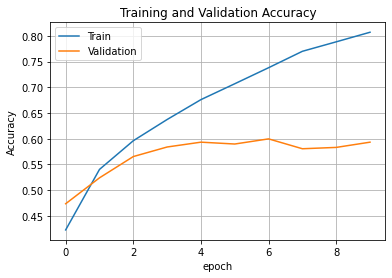

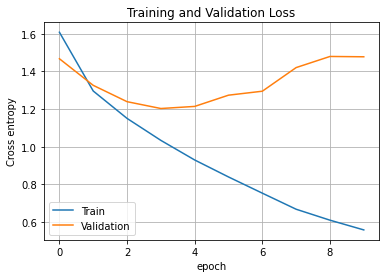

In [28]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()